In [1]:
import sys, pathlib

PROJECT_ROOT = pathlib.Path.cwd().parent  # LearningG2
sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

# Import libraries
import tensorflow as tf
import numpy as np
import os
import yaml
import pickle as pickle
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

tfk = tf.keras
# Setup path for cymetric package

_parent_dir = pathlib.Path.cwd().parent.parent
_cymetric_dir = _parent_dir / "cymetric"

if str(_parent_dir) not in sys.path:
    sys.path.insert(0, str(_parent_dir))
if str(_cymetric_dir) not in sys.path:
    sys.path.insert(0, str(_cymetric_dir))

# Create alias to fix cymetric internal imports
import cymetric
if hasattr(cymetric, 'cymetric'):
    sys.modules['cymetric'] = cymetric.cymetric

# Import functions
from geometry.geometry import kahler_form_real_matrix, holomorphic_volume_real_imag, compute_gG2
# # from ..geometry.patches import CoordChange_C5R10
from geometry.wedge import wedge
# from models.model import get_model_path

# Import cymetric functions
from cymetric.pointgen.pointgen import PointGenerator
from cymetric.models.helper import prepare_basis
from cymetric.models.models import MultFSModel

PROJECT_ROOT: /Users/tomassilva/Desktop/GitHub/LearningG2


/opt/homebrew/Caskroom/miniforge/base/envs/g2_ml/lib/python3.9/importlib/__init__.py:127: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _bootstrap._gcd_import(name[level:], package, level)


# Checking $\mathrm{G}_2$ identities over g2\_dataset

Let $K_f$ be the $S^1$ bundle over a CY manifold $(M, \omega)$

To ensure numerical consistency, we check the following identities of $\varphi \in \Omega^3(K_f)$ and $\psi:=\star_\varphi \varphi \in \Omega^4(K_f)$ (see [https://arxiv.org/pdf/math/0702077](https://arxiv.org/pdf/math/0702077)):

- $\varphi \wedge \psi = 7 \text{Vol}(K_f, g_{\varphi})$
- $d\psi = 0$
- $d\varphi = \omega^2$

## Loading data

In [2]:
data = np.load("../sampling/g2_dataset.npz")
data.files

['base_points',
 'link_points',
 'rotations',
 'phis',
 'psis',
 'riemannian_metrics',
 'g2_metrics',
 'drop_maxs',
 'drop_ones',
 'etas']

In [3]:
phis = data["phis"]
psis = data["psis"]
gG2s = data["g2_metrics"]

## Check $\varphi \wedge \psi = 7 \text{Vol}(K_f, g_{\varphi})$

In [4]:
vals = []
for i in tqdm(range(100000, 100100, 1)):
    phi = phis[i]
    psi = psis[i]

    gG2 = gG2s[i]

    prod = wedge(phi, psi)[0,1,2,3,4,5,6]


    vol = np.sqrt(np.linalg.det(gG2))


    vals.append(prod / vol)

100%|██████████| 100/100 [00:11<00:00,  8.80it/s]


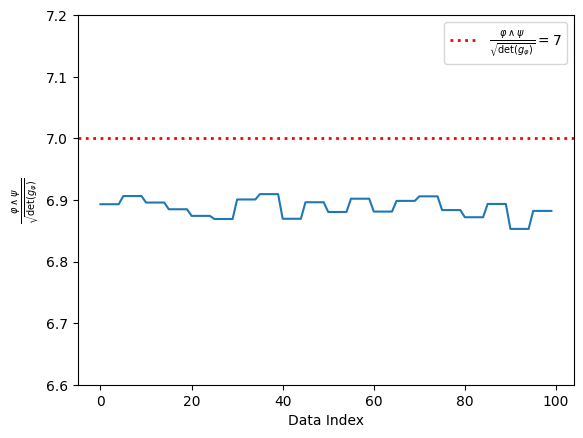

In [5]:
plt.plot(vals)
plt.xlabel("Data Index")
plt.ylabel(r"$\frac{\varphi\wedge\psi}{\sqrt{\det(g_{\varphi})}}$")

plt.axhline(
    y=7,
    linestyle=":",
    linewidth=2,
    color="red",
    label=r"$\frac{\varphi\wedge\psi}{\sqrt{\det(g_{\varphi})}}=7$"
)
plt.ylim(6.6, 7.2) 
plt.legend()
plt.show()

## Check $d\psi = 0$

Loading the trained CYmetric model

In [46]:
dirname = '../models/cy_models/train_data'

data = np.load(os.path.join(dirname, 'dataset.npz'))
BASIS = np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True)

BASIS = prepare_basis(BASIS)

nlayer = 3
nHidden = 64
act = 'gelu'
nEpochs = 500
bSizes = [64, 50000]
alpha = [1., 1., 1., 1., 1.]
nfold = 3
n_in = 2*5
n_out = nfold**2

nn = tf.keras.Sequential()
nn.add(tfk.Input(shape=(n_in,)))
for i in range(nlayer):
    nn.add(tfk.layers.Dense(nHidden, activation=act))
nn.add(tfk.layers.Dense(n_out, use_bias=False))

loaded_nn = tf.keras.models.load_model("../models/cy_models/cy_metric_model.keras")
fmodel = MultFSModel(loaded_nn, BASIS, alpha=alpha)


Utility functions

In [51]:
def _find_max_dQ_coords(points):
    r"""Finds the coordinates for which |dQ/dz| is largest.

    Args:
        points (ndarray[(n_p, ncoords), np.complex128]): Points.

    Returns:
        ndarray[(n_p), np.int64]: max(dQdz) indices
    """
    dQdz = np.abs(_compute_dQdz(points))
    dQdz = dQdz * (~np.isclose(points, complex(1, 0)))
    return np.argmax(dQdz, axis=-1)

def _compute_dQdz(points):
        r"""Computes dQdz at each point.

        Args:
            points (ndarray([n_p, ncoords], np.complex128)): Points.

        Returns:
            ndarray([n_p, ncoords], np.complex): dQdz at each point.
        """
        p_exp = np.expand_dims(np.expand_dims(points, 1), 1)
        dQdz = np.power(p_exp, BASIS['DQDZB0'])
        dQdz = np.multiply.reduce(dQdz, axis=-1)
        dQdz = np.multiply(BASIS['DQDZF0'], dQdz)
        dQdz = np.add.reduce(dQdz, axis=-1)
        return dQdz
    
def holomorphic_volume_real_imag(c):
    """
    Omega = c * dz1 ∧ dz2 ∧ dz3, with z_i = x_i + i y_i.
    Returns ReOmega, ImOmega as real (6,6,6) arrays in basis
    (x1, x2, x3, y1, y2, y3).

    Convention: Omega = (1/3!) * Omega_{ijk} e^i∧e^j∧e^k
    so Omega_{ijk} is fully antisymmetric.
    """
    dz1 = np.zeros(6, dtype=np.complex128)
    dz2 = np.zeros(6, dtype=np.complex128)
    dz3 = np.zeros(6, dtype=np.complex128)

    dz1[0] = 1.0; dz1[3] = 1.0j  # dx1 + i dy1
    dz2[1] = 1.0; dz2[4] = 1.0j  # dx2 + i dy2
    dz3[2] = 1.0; dz3[5] = 1.0j  # dx3 + i dy3

    T = np.einsum("i,j,k->ijk", dz1, dz2, dz3)

    # 6 * antisymmetrization: sum_{σ∈S3} sgn(σ) T_{σ(i)σ(j)σ(k)}
    Omega = c * (
        T
        + np.transpose(T, (1, 2, 0))
        + np.transpose(T, (2, 0, 1))
        - np.transpose(T, (0, 2, 1))
        - np.transpose(T, (2, 1, 0))
        - np.transpose(T, (1, 0, 2))
    )

    return Omega.real, Omega.imag

def kahler_form_real_matrix(g, half=False):
    """
    g: (n, n) complex Hermitian matrix g_{j \bar{k}}
    returns: (2n, 2n) real antisymmetric matrix W for ω
             in the basis (x1,...,xn,y1,...,yn)
    Convention: ω = i * sum g_{j\bar k} dz^j ∧ d\bar z^k
                (set half=True for ω = (i/2) ... )
    """
    n = g.shape[0]
    W = np.zeros((2*n, 2*n), dtype=float)

    for j in range(n):
        for k in range(n):
            a = g[j, k].real
            b = g[j, k].imag
            xj, yj = j, n + j
            xk, yk = k, n + k

            # Re(g): a (dx^j∧dy^k - dy^j∧dx^k)
            W[xj, yk] += a
            W[yk, xj] -= a
            W[yj, xk] -= a
            W[xk, yj] += a

            # Im(g): -b (dx^j∧dx^k + dy^j∧dy^k)
            W[xj, xk] += -b
            W[xk, xj] -= -b
            W[yj, yk] += -b
            W[yk, yj] -= -b

    if half:
        W *= 0.5

    # optional numerical hygiene:
    W = 0.5 * (W - W.T)

    return W

In [57]:
def quintic_solver(p, drop_max, drop_one):
    p_cc = p[0:3]+1.j*p[3:]
    new_dependent = (-1-p_cc[0]**5-p_cc[1]**5-p_cc[2]**5)**(1/5)
    
    ret = [None]*10
    ret[drop_one] = 1.0
    ret[drop_one+5] = 0.0
    
    ret[drop_max] = float(new_dependent.real)
    ret[drop_max+5] = float(new_dependent.imag)
    
    j=0
    for i in range(5):
        if ret[i] is None:
            ret[i] = float(p[j])
            ret[i+5] = float(p[j+3])
            j+=1
    return np.expand_dims(np.array(ret, dtype=np.float64), axis=0)

def sampler_g2_package_R7(p):
        point_cc = p[0:5] + 1.j*p[5:]
        drop_max = int(_find_max_dQ_coords(point_cc))
        drop_one = int(np.argmin(np.abs(point_cc - 1)))

        w = kahler_form_real_matrix(np.array(fmodel(np.expand_dims(p, axis=0))[0]))

        w_R7 = np.pad(w, ((0, 1), (0, 1)), mode='constant')

        holomorphic_volume_form = 1/(5*point_cc[drop_max]**4)

        ReOmega, ImOmega = holomorphic_volume_real_imag(holomorphic_volume_form)

        ReOmega_R7 = np.pad(ReOmega, ((0, 1), (0, 1), (0, 1)), mode='constant')
        ImOmega_R7 = np.pad(ImOmega, ((0, 1), (0, 1), (0, 1)), mode='constant')

        u_coords = [i for i in range(5) if i != drop_max and i != drop_one]

        eta = np.array([0,0,0,0,0,0,1], dtype=np.float64)

        u_count = 0
        for i in u_coords:
                factor = point_cc[i].conjugate() - (point_cc[drop_max].conjugate()*(point_cc[i]**4/point_cc[drop_max]**4))
                factor = factor / np.linalg.norm(point_cc)**2
                
                eta[u_count] = factor.imag
                eta[u_count+3] = factor.real
                
                u_count += 1
        
        g2 = wedge(w_R7, eta) + ReOmega_R7

        star_g2 = (1/2)*wedge(w_R7, w_R7) + wedge(eta, ImOmega_R7)
        
        return g2, star_g2
    

In [60]:
def sample_numerical_star_g2_neighborhood_val(sampler, point, epsilon):
    """
    Sample numerical values of a k-form at a (cubic) neighborhood of a point
    :param sampler: function to sample the k-form
    :param point: point at which to sample (center of a cube)
    :param epsilon: distance from the point to the neighborhood points
    :return: numerical values of the k-form at the neighborhood points as a dictionary
    6-dimensional dictionary with keys '0' to '6', where '0' is the center point and '1' to '6' are the -+ epsilon* canonical basis vectors 
    """
    point_cc = point[0:5] + 1.j*point[5:]
    drop_max = int(_find_max_dQ_coords(point_cc))
    drop_one = int(np.argmin(np.abs(point_cc - 1)))
    p_cc = np.delete(point_cc, [drop_max, drop_one])

    # p = np.array(point)
    p = np.concatenate([p_cc.real, p_cc.imag]) #Point in 6d

    directions = [np.array(np.eye(6, dtype=int)[i]) for i in range(6)]


    # X_rotated_plus = point_cc * np.exp(1j*epsilon)
    # X_rotated_plus = np.concatenate([X_rotated_plus.real, X_rotated_plus.imag])


    # X_rotated_minus = point_cc * np.exp(-1j*epsilon)
    # X_rotated_minus = np.concatenate([X_rotated_minus.real, X_rotated_minus.imag])
    
    X_rotated_plus = point_cc * np.exp(1j*global_epsilon)
    aux_one = int(np.argmin(np.abs(X_rotated_plus - 1)))
    X_rotated_plus = X_rotated_plus / X_rotated_plus[aux_one]
    X_rotated_plus[aux_one] = 1.0
    X_rotated_plus = np.concatenate([X_rotated_plus.real, X_rotated_plus.imag])

    X_rotated_minus = point_cc * np.exp(-1j*global_epsilon)
    aux_one = int(np.argmin(np.abs(X_rotated_minus - 1)))
    X_rotated_minus = X_rotated_minus / X_rotated_minus[aux_one]
    X_rotated_minus[aux_one] = 1.0
    X_rotated_minus = np.concatenate([X_rotated_minus.real, X_rotated_minus.imag])


    v0 = sampler(quintic_solver(p, drop_max, drop_one)[0])
    v1p = sampler(quintic_solver(p + epsilon*directions[0], drop_max, drop_one)[0])
    v1m = sampler(quintic_solver(p - epsilon*directions[0], drop_max, drop_one)[0])
    v2p = sampler(quintic_solver(p + epsilon*directions[1], drop_max, drop_one)[0])
    v2m = sampler(quintic_solver(p - epsilon*directions[1], drop_max, drop_one)[0])
    v3p = sampler(quintic_solver(p + epsilon*directions[2], drop_max, drop_one)[0])
    v3m = sampler(quintic_solver(p - epsilon*directions[2], drop_max, drop_one)[0])
    v4p = sampler(quintic_solver(p + epsilon*directions[3], drop_max, drop_one)[0])
    v4m = sampler(quintic_solver(p - epsilon*directions[3], drop_max, drop_one)[0])
    v5p = sampler(quintic_solver(p + epsilon*directions[4], drop_max, drop_one)[0])
    v5m = sampler(quintic_solver(p - epsilon*directions[4], drop_max, drop_one)[0])
    v6p = sampler(quintic_solver(p + epsilon*directions[5], drop_max, drop_one)[0])
    v6m = sampler(quintic_solver(p - epsilon*directions[5], drop_max, drop_one)[0])

    v7p = sampler(X_rotated_plus)
    v7m = sampler(X_rotated_minus)
    
    
    
    values = {"0": [v0],
            "1": [v1m, v1p],
            "2": [v2m, v2p],
            "3": [v3m, v3p], 
            "4": [v4m, v4p], 
            "5": [v5m, v5p], 
            "6": [v6m, v6p],
            "7": [v7m, v7p]
            } 
    

            
    return values


    
def numerical_d_g2(k_form_neighborhood_vals, epsilon):
    # d\omega_p(X_0, ..., X_k) \approx \frac{1}{\text{vol}(\sigma)} \int_{\partial \sigma} \omega 
    # where \sigma is a small k-dimensional block generated by X_0, ..., X_k
    # ----
    # Also, remember g_{ij}(x) = \delta_{ij} - \frac{1}{3} R_{ikjl}(0) \, x^k x^l + \mathcal{O}(|x|^3) = 
    #                          =\delta_{ij} + \mathcal{O}(|x|^3), 
    # since R_{ikjl} = 0 for Ricci-flat manifolds (which we assume here)
    # Thus, the volume of the k-dimensional block is approximately (2e)^k 
    # ----
    # Note for future Tomas: (-1)xSign convention of Acker's Book!
    """
    Compute the numerical exterior derivative of a k-form at a point using neighborhood values
    :param k_form_neighborhood_vals: dictionary of neighborhood values of the k-form
    :param g: metric tensor (needed for computing hypercube volume)
    :param e: small value to approximate the derivative
    :return: numerical exterior derivative of the k-form a the point k_form_neighborhood_vals["0"] as a numpy array
    """
    
    k = len(k_form_neighborhood_vals["0"][0].shape)
    
    # If the k-form is a 0-form (scalar field)
    if k == 0: 
        dw = np.zeros(7)
        for i in range(7):
            dw[i] = (1/(2*epsilon))*(k_form_neighborhood_vals[str(i+1)][1] - k_form_neighborhood_vals[str(i+1)][0])
        return dw
    
    # If the k-form is a 1-form
    elif k == 1:
        dw = np.zeros((7,7))
        for i in range(7):
            for j in range(7):
                if i!=j:
                    dw[i,j] = (1/(2*epsilon))*(k_form_neighborhood_vals[str(j+1)][0][i] +\
                                                k_form_neighborhood_vals[str(i+1)][1][j] -\
                                                k_form_neighborhood_vals[str(j+1)][1][i] -\
                                                k_form_neighborhood_vals[str(i+1)][0][j])
        
        return dw
    
    # If the k-form is a 2-form
    elif k == 2:
        dw = np.zeros((7,7,7))      
        for i in range(7):
            for j in range(7):
                for k in range(7):
                    if i!=j and j!=k and i!=k:
                        dw[i,j,k] = (1/(2*epsilon))*(+k_form_neighborhood_vals[str(i+1)][1][j,k] -\
                                                k_form_neighborhood_vals[str(i+1)][0][j,k] -\
                                                k_form_neighborhood_vals[str(j+1)][1][i,k] +\
                                                k_form_neighborhood_vals[str(j+1)][0][i,k] +\
                                                k_form_neighborhood_vals[str(k+1)][1][i,j] -\
                                                k_form_neighborhood_vals[str(k+1)][0][i,j])
        return dw

    elif k == 3:
        dw = np.zeros((7,7,7,7))      
        for i in range(7):
            for j in range(7):
                for k in range(7):
                    for l in range(7):
                        if i!=j and j!=k and k!=l and i!=k and i!=l and j!=l:
                            dw[i,j,k,l] = (1/(2*epsilon))*(+k_form_neighborhood_vals[str(i+1)][1][j,k,l] -\
                                                    k_form_neighborhood_vals[str(i+1)][0][j,k,l] -\
                                                    k_form_neighborhood_vals[str(j+1)][1][i,k,l] +\
                                                    k_form_neighborhood_vals[str(j+1)][0][i,k,l] +\
                                                    k_form_neighborhood_vals[str(k+1)][1][i,j,l] -\
                                                    k_form_neighborhood_vals[str(k+1)][0][i,j,l] -\
                                                    k_form_neighborhood_vals[str(l+1)][1][i,j,k] +\
                                                    k_form_neighborhood_vals[str(l+1)][0][i,j,k])
        return dw
    elif k ==4:
        dw = np.zeros((7,7,7,7,7))      
        for i in range(7):
            for j in range(7):
                for k in range(7):
                    for l in range(7):
                        for m in range(7):
                            if i!=j and j!=k and k!=l and l!=m and i!=k and i!=l and i!=m and j!=l and j!=m and k!=m:
                                dw[i,j,k,l,m] = (1/(2*epsilon))*(+k_form_neighborhood_vals[str(i+1)][1][j,k,l,m] -\
                                                        k_form_neighborhood_vals[str(i+1)][0][j,k,l,m] -\
                                                        k_form_neighborhood_vals[str(j+1)][1][i,k,l,m] +\
                                                        k_form_neighborhood_vals[str(j+1)][0][i,k,l,m] +\
                                                        k_form_neighborhood_vals[str(k+1)][1][i,j,l,m] -\
                                                        k_form_neighborhood_vals[str(k+1)][0][i,j,l,m] -\
                                                        k_form_neighborhood_vals[str(l+1)][1][i,j,k,m] +\
                                                        k_form_neighborhood_vals[str(l+1)][0][i,j,k,m] +\
                                                        k_form_neighborhood_vals[str(m+1)][1][i,j,k,l] -\
                                                        k_form_neighborhood_vals[str(m+1)][0][i,j,k,l])
        return dw

def sampler_star_g2_R7(p):
    _, psi = sampler_g2_package_R7(p)
    return psi

def sampler_g2_R7(p):
    phi, _ = sampler_g2_package_R7(p)
    return phi          

In [189]:
global_epsilon = 1e-12
vals_dpsi = []
vals_dphi = []
vals_ratio = []
for i in tqdm(range(100)):
    point = data['base_points'][i]
    dic_star_form = sample_numerical_star_g2_neighborhood_val(sampler_star_g2_R7, point, global_epsilon)

    numerical_exterior_d_star_g2 = numerical_d_g2(dic_star_form, global_epsilon)
    vals_dpsi.append(np.linalg.norm(numerical_exterior_d_star_g2))
    # print("||d\psi|| =", np.linalg.norm(numerical_exterior_d_star_g2)/24)

    dic_g2_form = sample_numerical_star_g2_neighborhood_val(sampler_g2_R7, point, global_epsilon)
    numerical_exterior_d_g2 = numerical_d_g2(dic_g2_form, global_epsilon)
    # print("||d\phi||=", np.linalg.norm(numerical_exterior_d_g2))
    vals_dphi.append(np.linalg.norm(numerical_exterior_d_g2))

    w = kahler_form_real_matrix(np.array(fmodel(np.expand_dims(point, axis=0))[0]))
    w_R7 = np.pad(w, ((0, 1), (0, 1)), mode='constant')
    w2 = wedge(w_R7, w_R7)

    # print("||w^2|| =", np.linalg.norm(w2))

    # print("||w^2 - d\phi|| =", np.linalg.norm(w2-numerical_exterior_d_g2))

    # print("Ratio ||d\phi||/||w^2|| =", np.linalg.norm(numerical_exterior_d_g2)/np.linalg.norm(w2))
    vals_ratio.append(np.linalg.norm(numerical_exterior_d_g2)/np.linalg.norm(w2))

100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


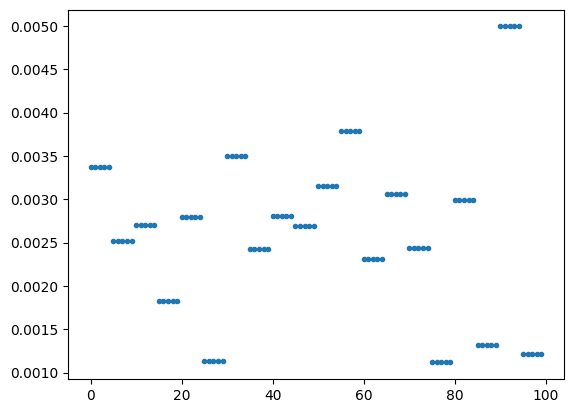

In [190]:
plt.plot(vals_dpsi, marker='.', linestyle='None')

In [186]:
vals_dphi

[np.float64(2.398437927396864),
 np.float64(2.398437927396864),
 np.float64(2.398437927396864),
 np.float64(2.398437927396864),
 np.float64(2.398437927396864),
 np.float64(2.79649407112545),
 np.float64(2.79649407112545),
 np.float64(2.79649407112545),
 np.float64(2.79649407112545),
 np.float64(2.79649407112545),
 np.float64(2.421532619352741),
 np.float64(2.421532619352741),
 np.float64(2.421532619352741),
 np.float64(2.421532619352741),
 np.float64(2.421532619352741),
 np.float64(2.3703550764436643),
 np.float64(2.3703550764436643),
 np.float64(2.3703550764436643),
 np.float64(2.3703550764436643),
 np.float64(2.3703550764436643),
 np.float64(2.3435852803650348),
 np.float64(2.3435852803650348),
 np.float64(2.3435852803650348),
 np.float64(2.3435852803650348),
 np.float64(2.3435852803650348),
 np.float64(2.135024088912553),
 np.float64(2.135024088912553),
 np.float64(2.135024088912553),
 np.float64(2.135024088912553),
 np.float64(2.135024088912553),
 np.float64(3.0573537946367675),
 n

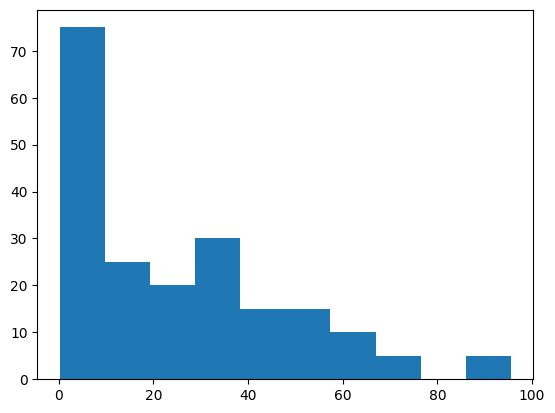

In [177]:
# plt.figure()
# plt.hist(vals_dpsi, bins=100)
# plt.show()

x = np.array(vals_dpsi)  # your data

q_low, q_high = np.percentile(x, [1, 99])  # or [0.5, 99.5]
x_cut = x[(x >= q_low) & (x <= q_high)]

plt.figure()
plt.hist(x_cut, bins=10)
plt.show()

In [171]:
x = np.array(vals_ratio)
np.median(x)

np.float64(3.1908573958579542)

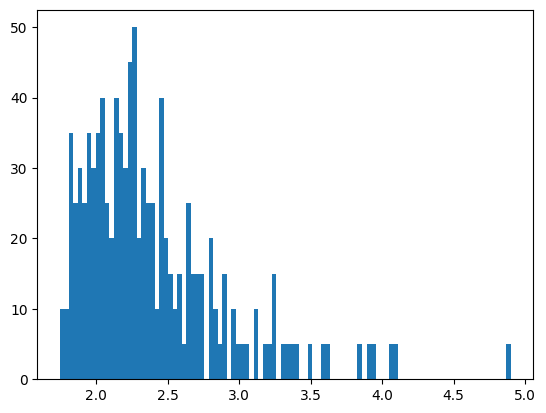

In [162]:
# plt.figure()
# plt.hist(vals_dphi, bins=100)
# plt.show()
x = np.array(vals_dphi)  # your data

q_low, q_high = np.percentile(x, [1, 99])  # or [0.5, 99.5]
x_cut = x[(x >= q_low) & (x <= q_high)]

plt.figure()
plt.hist(x_cut, bins=100)
plt.show()

In [149]:
np.array(vals_ratio[:990]).mean()

np.float64(3.265095095313548)

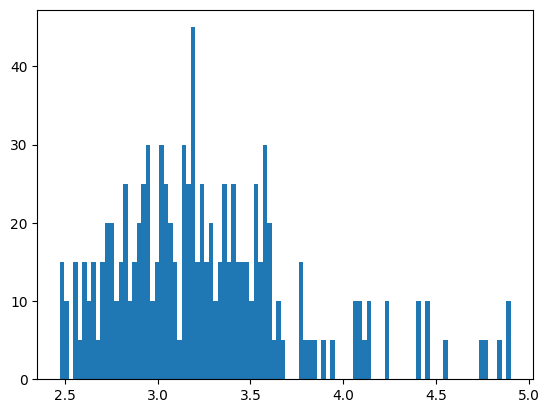

In [161]:
# plt.plot(vals_ratio[:990], marker='.', linestyle='None')
# plt.show()
x = np.array(vals_ratio)  # your data

q_low, q_high = np.percentile(x, [1, 99])  # or [0.5, 99.5]
x_cut = x[(x >= q_low) & (x <= q_high)]

plt.figure()
plt.hist(x_cut, bins=100)

plt.show()
    